In [1]:
import simulacion as s
import ROOT as root
import numpy as np
import matplotlib.pyplot as plt
import random

Welcome to JupyROOT 6.30/04


## Voy a revisar las funciones anteriores

In [2]:

def matriz_uniform(N_pix, C_med, t=0, k=0):                                                   
    matriz_cuentas = np.zeros((N_pix,N_pix))
    for i in range(N_pix):
        for j in range(N_pix):
            matriz_cuentas[i,j] = np.random.normal(C_med, np.sqrt(C_med))
    if(t!=0 and k!=0):
        n=int(t*(N_pix/64))
        for i in range(int(N_pix/2),int(N_pix/2)+n):
            for j in range(int(N_pix/2),int(N_pix/2)+n):
                matriz_cuentas[i,j] = np.random.normal((1+k/100)*C_med, np.sqrt((1+k/100)*C_med))
    return matriz_cuentas
        

def filtro9p(matriz):
    N_pix = matriz.shape[0]
    matriz_filtrada = np.zeros((N_pix,N_pix))
    
    for i in range(0,N_pix):
        for j in range(0,N_pix):
            if(i!=0 and i!=N_pix-1 and j!=0 and j!=N_pix-1):
                P1=matriz[i-1,j-1]
                P2=matriz[i-1,j]
                P3=matriz[i-1,j+1]
                P4=matriz[i,j-1]
                P5=matriz[i,j]
                P6=matriz[i,j+1]
                P7=matriz[i+1,j-1]
                P8=matriz[i+1,j]
                P9=matriz[i+1,j+1]
                matriz_filtrada[i,j]=(P1*1 + P2*2 + P3*1 +2*P4 + 4*P5 + 2*P6 + 1*P7 + 2*P8 + 1*P9)/(16)
            else:
                matriz_filtrada[i,j]=matriz[i,j]
    
    return matriz_filtrada


def fov(Npix, matriz):
    if(Npix==64):
        fdeleted = 3
        cdeleted = 11
    if(Npix==128):
        fdeleted = 6
        cdeleted = 22
    #Now i want to extract a numpy submatriz removing fdelected rows on each side and cdeleted columns on each side
    submatrix = matriz[fdeleted:-fdeleted, cdeleted:-cdeleted]
    return submatrix

def ui(matrix):
    Cmax = np.max(matrix)
    Cmin = np.min(matrix)
    UI = 100*(Cmax-Cmin)/(Cmax+Cmin)
    return UI

1.5360107105124587

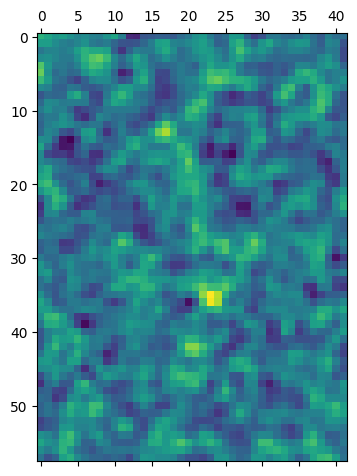

In [3]:
m = matriz_uniform(64,8000,1,1)
m2 = filtro9p(m)
m3 = fov(64,m2)
plt.matshow(m3)
ui(m3)


## Prueba de control de calidad 5Mc

In [4]:
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
num_cuentas = 1000
filas_eliminadas = 0
columnas_eliminadas = 0
Cmed = 35714
t = 1
k = 3
tolerancia = 0.7

In [19]:
def prueba5mc(num_cuentas):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    tolerancia = 2.925
    t = 4
    k = 3
    z95 = 1.960

    for i in range(num_cuentas):
        num_aleatorio = random.random()
        if num_aleatorio < 0.1:
            matrix = matriz_uniform(64, 2232, t, k)
            matrix = filtro9p(matrix)
            matrix = fov(64, matrix)
            UI = ui(matrix)
            if UI < tolerancia:
                false_negative += 1
            else:
                true_positive += 1
        else:
            matrix = matriz_uniform(64, 2232)
            matrix = filtro9p(matrix)
            matrix = fov(64, matrix)
            UI = ui(matrix)
            if UI < tolerancia:
                true_negative += 1
            else:
                false_positive += 1

    FVP = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    sigma_FVP = np.sqrt(true_positive * false_negative / ((true_positive + false_negative) ** 3)) if true_positive + false_negative > 0 else 0
    FVN = true_negative / (true_negative + false_positive) if true_negative + false_positive > 0 else 0
    sigma_FVN = np.sqrt(false_positive * true_negative / ((false_positive + true_negative) ** 3)) if false_positive + true_negative > 0 else 0
    FFP = false_positive / (true_negative + false_positive) if true_negative + false_positive > 0 else 0
    FFN = false_negative / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    LRP = FVP / FFP if FFP > 0 else float('inf')
    sigma_LRP = np.sqrt((1 - FVP) / true_positive + FVN / true_positive) if true_positive > 0 else 0
    LRN = FFN / FVN if FVN > 0 else float('inf')
    sigma_LRN = np.sqrt(FVP / true_negative + (1 - FVN) / true_negative) if true_negative > 0 else 0
    PD = (true_positive + false_negative) / num_cuentas if num_cuentas > 0 else 0

    VPP = (PD * FVP) / (PD * FVP + (1 - PD) * FFP) if PD * FVP + (1 - PD) * FFP > 0 else 0
    sigma_VPP = np.sqrt(true_positive * false_positive / ((true_positive + false_positive) ** 3)) if true_positive + false_positive > 0 else 0
    VPN = (1 - PD) * FVN / (PD * FFN + (1 - PD) * FVN) if PD * FFN + (1 - PD) * FVN > 0 else 0
    sigma_VPN = np.sqrt(true_negative * false_negative / ((true_negative + false_negative) ** 3)) if true_negative + false_negative > 0 else 0

    results = {
        'true_positive': true_positive,
        'true_negative': true_negative,
        'false_positive': false_positive,
        'false_negative': false_negative,
        'FVP': FVP, 'sigma_FVP': sigma_FVP,
        'FVN': FVN, 'sigma_FVN': sigma_FVN,
        'FFP': FFP, 'FFN': FFN,
        'LRP': LRP, 'sigma_LRP': sigma_LRP,
        'LRN': LRN, 'sigma_LRN': sigma_LRN,
        'PD': PD,
        'VPP': VPP, 'sigma_VPP': sigma_VPP,
        'VPN': VPN, 'sigma_VPN': sigma_VPN
    }

    for key, value in results.items():
        print(f"{key}: {value:.4f}")

    # Intervalos de confianza al 95%
    intervals = {
        'FVP_confidence_interval': (FVP - z95 * sigma_FVP, FVP + z95 * sigma_FVP),
        'FVN_confidence_interval': (FVN - z95 * sigma_FVN, FVN + z95 * sigma_FVN),
        'LRP_confidence_interval': (LRP * np.exp(-z95 * sigma_LRP), LRP * np.exp(+z95 * sigma_LRP)),
        'LRN_confidence_interval': (LRN * np.exp(-z95 * sigma_LRN), LRN * np.exp(+z95 * sigma_LRN)),
        'VPP_confidence_interval': (VPP - z95 * sigma_VPP, VPP + z95 * sigma_VPP),
        'VPN_confidence_interval': (VPN - z95 * sigma_VPN, VPN + z95 * sigma_VPN)
    }

    for key, value in intervals.items():
        print(f"{key}: ({value[0]:.4f}, {value[1]:.4f})")

prueba5mc(1800)

true_positive: 150.0000
true_negative: 1377.0000
false_positive: 228.0000
false_negative: 45.0000
FVP: 0.7692
sigma_FVP: 0.0302
FVN: 0.8579
sigma_FVN: 0.0087
FFP: 0.1421
FFN: 0.2308
LRP: 5.4150
sigma_LRP: 0.0852
LRN: 0.2690
sigma_LRN: 0.0257
PD: 0.1083
VPP: 0.3968
sigma_VPP: 0.0252
VPN: 0.9684
sigma_VPN: 0.0046
FVP_confidence_interval: (0.7101, 0.8284)
FVN_confidence_interval: (0.8409, 0.8750)
LRP_confidence_interval: (4.5822, 6.3991)
LRN_confidence_interval: (0.2558, 0.2829)
VPP_confidence_interval: (0.3475, 0.4461)
VPN_confidence_interval: (0.9593, 0.9775)


In [21]:
prueba5mc(1800)

true_positive: 156.0000
true_negative: 1375.0000
false_positive: 224.0000
false_negative: 45.0000
FVP: 0.7761
sigma_FVP: 0.0294
FVN: 0.8599
sigma_FVN: 0.0087
FFP: 0.1401
FFN: 0.2239
LRP: 5.5402
sigma_LRP: 0.0834
LRN: 0.2604
sigma_LRN: 0.0258
PD: 0.1117
VPP: 0.4105
sigma_VPP: 0.0252
VPN: 0.9683
sigma_VPN: 0.0046
FVP_confidence_interval: (0.7185, 0.8337)
FVN_confidence_interval: (0.8429, 0.8769)
LRP_confidence_interval: (4.7052, 6.5235)
LRN_confidence_interval: (0.2475, 0.2739)
VPP_confidence_interval: (0.3611, 0.4600)
VPN_confidence_interval: (0.9592, 0.9774)


In [23]:
def prueba40mc(num_cuentas):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    tolerancia = 1.025
    t = 2
    k = 2
    z95 = 1.960

    for i in range(num_cuentas):
        num_aleatorio = random.random()
        if num_aleatorio < 0.1:
            matrix = matriz_uniform(64, 17857, t, k)
            matrix = filtro9p(matrix)
            matrix = fov(64, matrix)
            UI = ui(matrix)
            if UI < tolerancia:
                false_negative += 1
            else:
                true_positive += 1
        else:
            matrix = matriz_uniform(64, 17857)
            matrix = filtro9p(matrix)
            matrix = fov(64, matrix)
            UI = ui(matrix)
            if UI < tolerancia:
                true_negative += 1
            else:
                false_positive += 1

    FVP = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    sigma_FVP = np.sqrt(true_positive * false_negative / ((true_positive + false_negative) ** 3)) if true_positive + false_negative > 0 else 0
    FVN = true_negative / (true_negative + false_positive) if true_negative + false_positive > 0 else 0
    sigma_FVN = np.sqrt(false_positive * true_negative / ((false_positive + true_negative) ** 3)) if false_positive + true_negative > 0 else 0
    FFP = false_positive / (true_negative + false_positive) if true_negative + false_positive > 0 else 0
    FFN = false_negative / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    LRP = FVP / FFP if FFP > 0 else float('inf')
    sigma_LRP = np.sqrt((1 - FVP) / true_positive + FVN / true_positive) if true_positive > 0 else 0
    LRN = FFN / FVN if FVN > 0 else float('inf')
    sigma_LRN = np.sqrt(FVP / true_negative + (1 - FVN) / true_negative) if true_negative > 0 else 0
    PD = (true_positive + false_negative) / num_cuentas if num_cuentas > 0 else 0

    VPP = (PD * FVP) / (PD * FVP + (1 - PD) * FFP) if PD * FVP + (1 - PD) * FFP > 0 else 0
    sigma_VPP = np.sqrt(true_positive * false_positive / ((true_positive + false_positive) ** 3)) if true_positive + false_positive > 0 else 0
    VPN = (1 - PD) * FVN / (PD * FFN + (1 - PD) * FVN) if PD * FFN + (1 - PD) * FVN > 0 else 0
    sigma_VPN = np.sqrt(true_negative * false_negative / ((true_negative + false_negative) ** 3)) if true_negative + false_negative > 0 else 0

    results = {
        'true_positive': true_positive,
        'true_negative': true_negative,
        'false_positive': false_positive,
        'false_negative': false_negative,
        'FVP': FVP, 'sigma_FVP': sigma_FVP,
        'FVN': FVN, 'sigma_FVN': sigma_FVN,
        'FFP': FFP, 'FFN': FFN,
        'LRP': LRP, 'sigma_LRP': sigma_LRP,
        'LRN': LRN, 'sigma_LRN': sigma_LRN,
        'PD': PD,
        'VPP': VPP, 'sigma_VPP': sigma_VPP,
        'VPN': VPN, 'sigma_VPN': sigma_VPN
    }

    for key, value in results.items():
        print(f"{key}: {value:.4f}")

    # Intervalos de confianza al 95%
    intervals = {
        'FVP_confidence_interval': (FVP - z95 * sigma_FVP, FVP + z95 * sigma_FVP),
        'FVN_confidence_interval': (FVN - z95 * sigma_FVN, FVN + z95 * sigma_FVN),
        'LRP_confidence_interval': (LRP * np.exp(-z95 * sigma_LRP), LRP * np.exp(+z95 * sigma_LRP)),
        'LRN_confidence_interval': (LRN * np.exp(-z95 * sigma_LRN), LRN * np.exp(+z95 * sigma_LRN)),
        'VPP_confidence_interval': (VPP - z95 * sigma_VPP, VPP + z95 * sigma_VPP),
        'VPN_confidence_interval': (VPN - z95 * sigma_VPN, VPN + z95 * sigma_VPN)
    }

    for key, value in intervals.items():
        print(f"{key}: ({value[0]:.4f}, {value[1]:.4f})")

prueba40mc(257)

true_positive: 21.0000
true_negative: 188.0000
false_positive: 45.0000
false_negative: 3.0000
FVP: 0.8750
sigma_FVP: 0.0675
FVN: 0.8069
sigma_FVN: 0.0259
FFP: 0.1931
FFN: 0.1250
LRP: 4.5306
sigma_LRP: 0.2107
LRN: 0.1549
sigma_LRN: 0.0754
PD: 0.0934
VPP: 0.3182
sigma_VPP: 0.0573
VPN: 0.9843
sigma_VPN: 0.0090
FVP_confidence_interval: (0.7427, 1.0073)
FVN_confidence_interval: (0.7562, 0.8576)
LRP_confidence_interval: (2.9981, 6.8464)
LRN_confidence_interval: (0.1336, 0.1796)
VPP_confidence_interval: (0.2058, 0.4306)
VPN_confidence_interval: (0.9667, 1.0019)


In [31]:
def prueba40mc(num_cuentas):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    tolerancia = 0.7
    t = 1
    k = 3
    z95 = 1.960

    for i in range(num_cuentas):
        num_aleatorio = random.random()
        if num_aleatorio < 0.1:
            matrix = matriz_uniform(64, 35714, t, k)
            matrix = filtro9p(matrix)
            matrix = fov(64, matrix)
            UI = ui(matrix)
            if UI < tolerancia:
                false_negative += 1
            else:
                true_positive += 1
        else:
            matrix = matriz_uniform(64, 35714)
            matrix = filtro9p(matrix)
            matrix = fov(64, matrix)
            UI = ui(matrix)
            if UI < tolerancia:
                true_negative += 1
            else:
                false_positive += 1

    FVP = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    sigma_FVP = np.sqrt(true_positive * false_negative / ((true_positive + false_negative) ** 3)) if true_positive + false_negative > 0 else 0
    FVN = true_negative / (true_negative + false_positive) if true_negative + false_positive > 0 else 0
    sigma_FVN = np.sqrt(false_positive * true_negative / ((false_positive + true_negative) ** 3)) if false_positive + true_negative > 0 else 0
    FFP = false_positive / (true_negative + false_positive) if true_negative + false_positive > 0 else 0
    FFN = false_negative / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    LRP = FVP / FFP if FFP > 0 else float('inf')
    sigma_LRP = np.sqrt((1 - FVP) / true_positive + FVN / true_positive) if true_positive > 0 else 0
    LRN = FFN / FVN if FVN > 0 else float('inf')
    sigma_LRN = np.sqrt(FVP / true_negative + (1 - FVN) / true_negative) if true_negative > 0 else 0
    PD = (true_positive + false_negative) / num_cuentas if num_cuentas > 0 else 0

    VPP = (PD * FVP) / (PD * FVP + (1 - PD) * FFP) if PD * FVP + (1 - PD) * FFP > 0 else 0
    sigma_VPP = np.sqrt(true_positive * false_positive / ((true_positive + false_positive) ** 3)) if true_positive + false_positive > 0 else 0
    VPN = (1 - PD) * FVN / (PD * FFN + (1 - PD) * FVN) if PD * FFN + (1 - PD) * FVN > 0 else 0
    sigma_VPN = np.sqrt(true_negative * false_negative / ((true_negative + false_negative) ** 3)) if true_negative + false_negative > 0 else 0

    results = {
        'true_positive': true_positive,
        'true_negative': true_negative,
        'false_positive': false_positive,
        'false_negative': false_negative,
        'FVP': FVP, 'sigma_FVP': sigma_FVP,
        'FVN': FVN, 'sigma_FVN': sigma_FVN,
        'FFP': FFP, 'FFN': FFN,
        'LRP': LRP, 'sigma_LRP': sigma_LRP,
        'LRN': LRN, 'sigma_LRN': sigma_LRN,
        'PD': PD,
        'VPP': VPP, 'sigma_VPP': sigma_VPP,
        'VPN': VPN, 'sigma_VPN': sigma_VPN
    }

    for key, value in results.items():
        print(f"{key}: {value:.4f}")

    # Intervalos de confianza al 95%
    intervals = {
        'FVP_confidence_interval': (FVP - z95 * sigma_FVP, FVP + z95 * sigma_FVP),
        'FVN_confidence_interval': (FVN - z95 * sigma_FVN, FVN + z95 * sigma_FVN),
        'LRP_confidence_interval': (LRP * np.exp(-z95 * sigma_LRP), LRP * np.exp(+z95 * sigma_LRP)),
        'LRN_confidence_interval': (LRN * np.exp(-z95 * sigma_LRN), LRN * np.exp(+z95 * sigma_LRN)),
        'VPP_confidence_interval': (VPP - z95 * sigma_VPP, VPP + z95 * sigma_VPP),
        'VPN_confidence_interval': (VPN - z95 * sigma_VPN, VPN + z95 * sigma_VPN)
    }

    for key, value in intervals.items():
        print(f"{key}: ({value[0]:.4f}, {value[1]:.4f})")

prueba40mc(60)

true_positive: 5.0000
true_negative: 38.0000
false_positive: 13.0000
false_negative: 4.0000
FVP: 0.5556
sigma_FVP: 0.1656
FVN: 0.7451
sigma_FVN: 0.0610
FFP: 0.2549
FFN: 0.4444
LRP: 2.1795
sigma_LRP: 0.4878
LRN: 0.5965
sigma_LRN: 0.1460
PD: 0.1500
VPP: 0.2778
sigma_VPP: 0.1056
VPN: 0.9048
sigma_VPN: 0.0453
FVP_confidence_interval: (0.2309, 0.8802)
FVN_confidence_interval: (0.6255, 0.8647)
LRP_confidence_interval: (0.8378, 5.6695)
LRN_confidence_interval: (0.4480, 0.7942)
VPP_confidence_interval: (0.0709, 0.4847)
VPN_confidence_interval: (0.8160, 0.9935)
